In [1]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
dataset = pd.read_excel('dataset.xlsx', index_col=0)

In [3]:
dataset['SARS-Cov-2 exam result'] = [0 if a == 'negative' else 1 for a in dataset['SARS-Cov-2 exam result'].values]

## Analysis of missing data

In [4]:
dataset.info(max_cols=111)

<class 'pandas.core.frame.DataFrame'>
Index: 5644 entries, 44477f75e8169d2 to 2697fdccbfeb7f7
Data columns (total 110 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Patient age quantile                                   5644 non-null   int64  
 1   SARS-Cov-2 exam result                                 5644 non-null   int64  
 2   Patient addmited to regular ward (1=yes, 0=no)         5644 non-null   int64  
 3   Patient addmited to semi-intensive unit (1=yes, 0=no)  5644 non-null   int64  
 4   Patient addmited to intensive care unit (1=yes, 0=no)  5644 non-null   int64  
 5   Hematocrit                                             603 non-null    float64
 6   Hemoglobin                                             603 non-null    float64
 7   Platelets                                              602 non-null    float64
 8   Mean platelet volume       

In [5]:
def plot_missing_data(missing_data, title):
    f, ax = plt.subplots(figsize=(15, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=missing_data.index, y=missing_data['Percent'])
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title(title, fontsize=15)

,Total,Percent
"Prothrombin time (PT), Activity",5644,1.000000
D-Dimer,5644,1.000000
Mycoplasma pneumoniae,5644,1.000000
Urine - Sugar,5644,1.000000
Partial thromboplastin time (PTT),5644,1.000000
Fio2 (venous blood gas analysis),5643,0.999823
Urine - Nitrite,5643,0.999823
Vitamin B12,5641,0.999468
Lipase dosage,5636,0.998583
Albumin,5631,0.997697


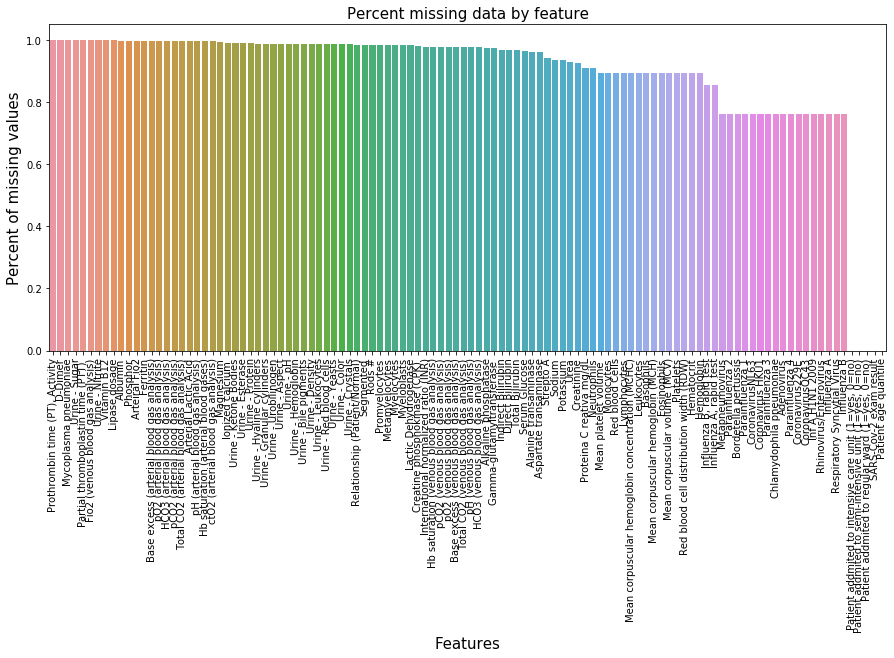

In [6]:
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
plot_missing_data(missing_data, 'Percent missing data by feature')
missing_data.head(10)

In [7]:
columns_to_exclude = missing_data.index[missing_data['Percent'] > 0.998].tolist()
dataset.drop(columns=columns_to_exclude, inplace=True)

,Total,Percent
Albumin,558,1.000000
Phosphor,557,0.998208
Ferritin,556,0.996416
Magnesium,553,0.991039
Ionized calcium,552,0.989247
Urine - Ketone Bodies,549,0.983871
Arteiral Fio2,549,0.983871
Rods #,549,0.983871
Segmented,549,0.983871
Promyelocytes,549,0.983871


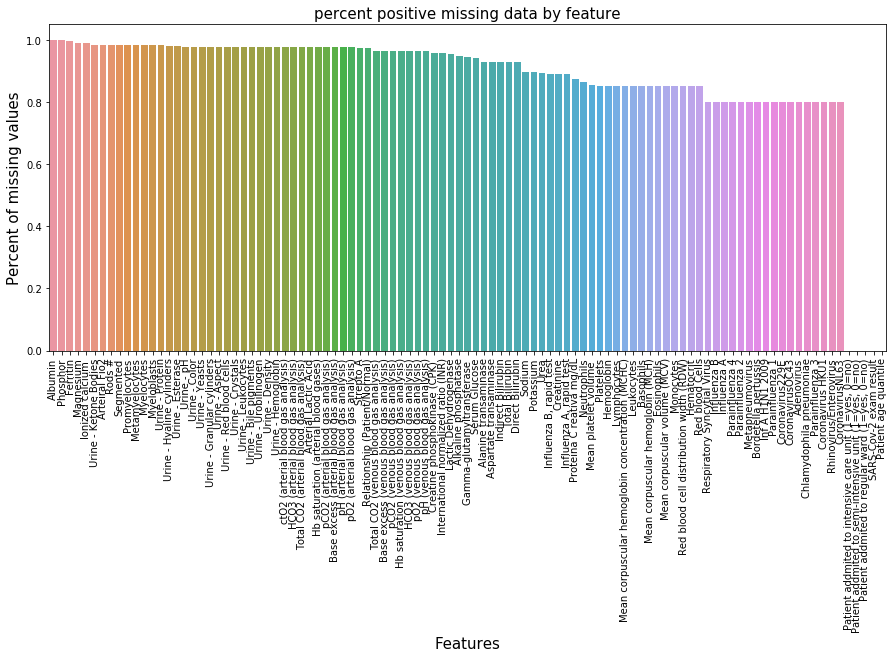

In [10]:
dataset_positive = dataset[dataset['SARS-Cov-2 exam result'] == 1]

total_positive = dataset_positive.isnull().sum().sort_values(ascending=False)
percent_positive = (dataset_positive.isnull().sum()/dataset_positive.isnull().count()).sort_values(ascending=False)
missing_data_positive = pd.concat([total_positive, percent_positive], axis=1, keys=['Total', 'Percent'])

plot_missing_data(missing_data_positive, 'percent positive missing data by feature')
missing_data_positive.head(10)

,Total,Percent
Arteiral Fio2,5075,0.997837
Albumin,5073,0.997444
ctO2 (arterial blood gas analysis),5072,0.997247
Arterial Lactic Acid,5072,0.997247
pO2 (arterial blood gas analysis),5072,0.997247
HCO3 (arterial blood gas analysis),5072,0.997247
Total CO2 (arterial blood gas analysis),5072,0.997247
pH (arterial blood gas analysis),5072,0.997247
Base excess (arterial blood gas analysis),5072,0.997247
pCO2 (arterial blood gas analysis),5072,0.997247


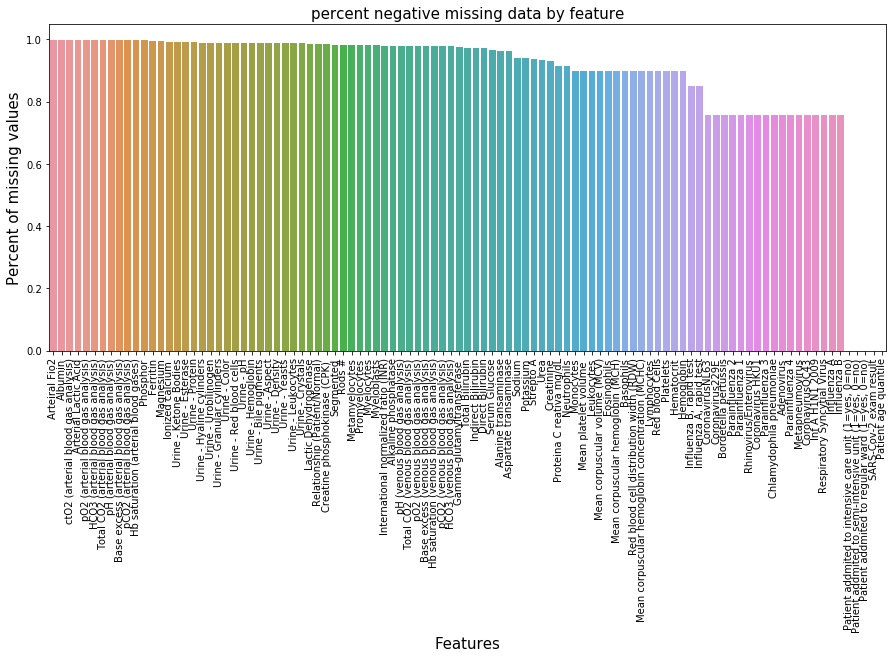

In [11]:
dataset_negative = dataset[dataset['SARS-Cov-2 exam result'] == 0]

total_negative = dataset_negative.isnull().sum().sort_values(ascending=False)
percent_negative = (dataset_negative.isnull().sum()/dataset_negative.isnull().count()).sort_values(ascending=False)
missing_data_negative = pd.concat([total_negative, percent_negative], axis=1, keys=['Total', 'Percent'])

plot_missing_data(missing_data_negative, 'percent negative missing data by feature')
missing_data_negative.head(10)

In [12]:
dataset.drop(columns=['Albumin'], inplace=True)

## Correlation Matrix

In [32]:
corrmat = abs(dataset.corr())

,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
Patient age quantile,1.00,0.08,0.05,0.02,-0.04,0.10,0.06,-0.16,0.12,-0.04,...,-0.22,-0.47,0.57,0.57,0.09,0.17,-0.10,-0.33,-0.51,-0.06
SARS-Cov-2 exam result,0.08,1.00,0.14,0.02,0.03,0.10,0.10,-0.28,0.11,0.12,...,0.13,-0.32,0.13,0.31,-0.25,-0.21,0.31,-0.31,-0.12,0.27
"Patient addmited to regular ward (1=yes, 0=no)",0.05,0.14,1.00,-0.01,-0.01,-0.09,-0.09,-0.18,-0.01,-0.05,...,0.20,-0.23,0.03,0.20,-0.16,-0.13,0.11,-0.17,NaN,0.27
"Patient addmited to semi-intensive unit (1=yes, 0=no)",0.02,0.02,-0.01,1.00,-0.01,-0.18,-0.18,0.01,-0.02,-0.14,...,-0.56,0.11,-0.23,-0.18,-0.11,-0.14,-0.34,-0.09,0.19,-0.05
"Patient addmited to intensive care unit (1=yes, 0=no)",-0.04,0.03,-0.01,-0.01,1.00,-0.18,-0.18,0.13,-0.07,-0.12,...,0.35,0.30,0.20,-0.18,0.42,0.41,0.16,0.35,0.13,-0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HCO3 (arterial blood gas analysis),0.17,-0.21,-0.13,-0.14,0.41,-0.34,-0.42,0.13,0.27,-0.27,...,-0.35,0.51,0.64,-0.21,0.99,1.00,-0.30,0.10,-1.00,-0.43
pO2 (arterial blood gas analysis),-0.10,0.31,0.11,-0.34,0.16,0.12,0.08,-0.14,-0.23,0.20,...,0.80,-0.30,-0.09,0.20,-0.31,-0.30,1.00,-0.19,-1.00,0.27
Arteiral Fio2,-0.33,-0.31,-0.17,-0.09,0.35,0.07,-0.00,0.47,0.08,-0.26,...,-0.02,0.40,-0.26,-0.39,0.17,0.10,-0.19,1.00,1.00,-0.21
Phosphor,-0.51,-0.12,NaN,0.19,0.13,0.17,0.26,0.13,-0.22,0.19,...,-1.00,1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1.00,1.00,1.00


In [15]:
#Correlation with output variable
cor_target = corrmat["SARS-Cov-2 exam result"]
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1].index.tolist()

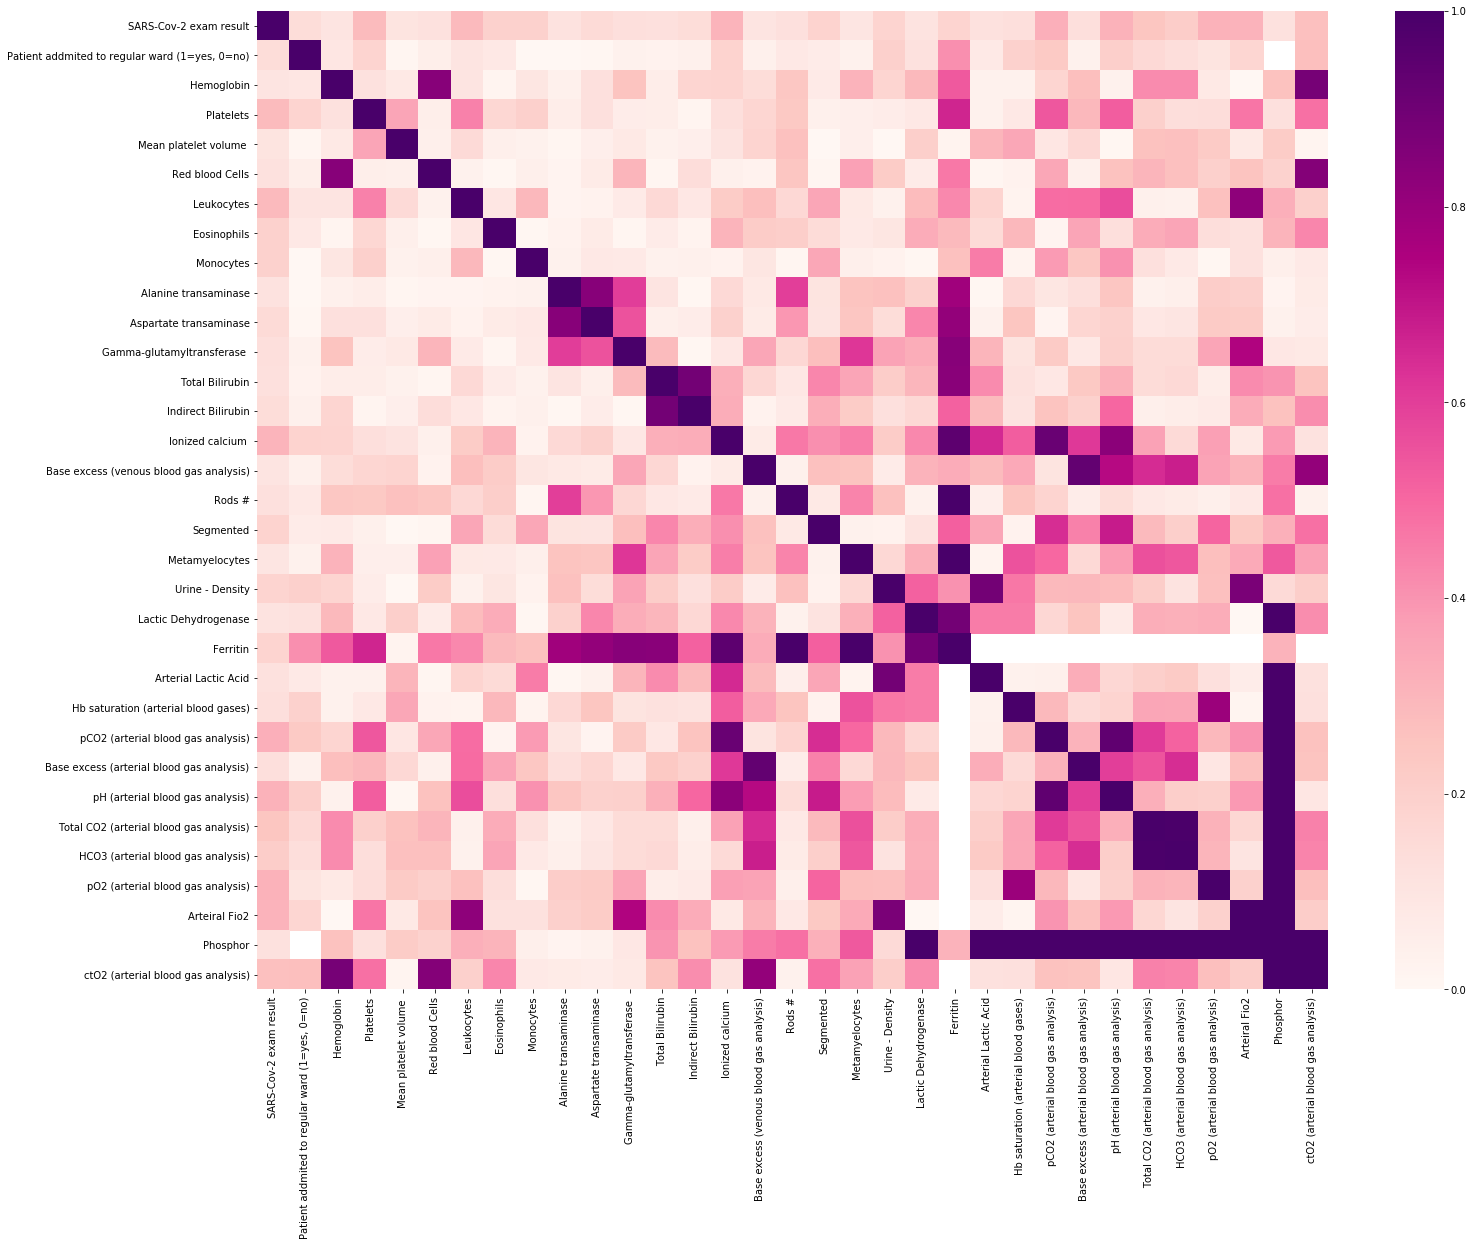

In [50]:
f, ax = plt.subplots(figsize=(24, 18))
sns.heatmap(abs(dataset[relevant_features].corr()), yticklabels=relevant_features, xticklabels=relevant_features, vmin = 0.0, vmax=1.0, cmap='RdPu')

## Negative and Positive Cases

In [37]:
nof_positive_cases = len(dataset_positive.index)
nof_negative_cases = len(dataset_negative.index)

(-1.1076132200227402,
 1.106918589509273,
 -1.1043893148273538,
 1.1002090207918012)

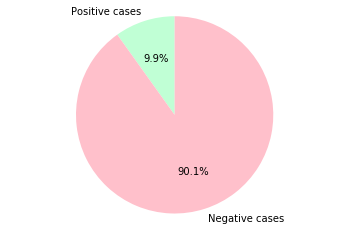

In [57]:
fig1, ax1 = plt.subplots()
ax1.pie([nof_positive_cases, nof_negative_cases], labels=['Positive cases', 'Negative cases'], autopct='%1.1f%%', startangle=90, colors=['#c0ffd5', '#ffc0cb'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.